# Group 20 - Prediciting Heart Disease

### Introduction
An ever prevalent issue within an individual's health is the threat of a heart disease. Being affected by a heart disease would be dangerous to a person and could be fatal. We aim to learn how to detect factors within individuals who may potentially be affected by heart disease in hopes of avoiding it. Things such as age, cholesterol levels (Wu et al., 2015), and heart rate (Custodis et al., 2013) are often associated with an individual’s health and can often indicate the state of their health). 

#### With that in mind, we wish to ask “can age, cholesterol, and resting heart rate help determine the likeliness for a person to have a heart disease?”. 

The data that will be used to answer this question comes from the Cleveland Database, it contains 14 categories within an individual’s health and labels their heart disease diagnosis on a scale from 0 to 4, 0 being no presence of a heart disease and 1 to 4 being the severity.

#### Table Columns:
1. Age
2. Sex (1 = male, 0 = female)
3. cp (Chest Pain Type)
4. trestbps (Resting Blood Pressure in in mm Hg)
5. chol (serum cholestrol level in mg/dl)
6. fbs (fasting blood sugar, if greater than 120 mg/dl = 1, if less than 120 mg/dl = 0)
7. restecg (resting electrocardiographic results)
8. thalach (maximum heart rate achieved)
9. exang (exercise induced angina)
10. oldpeak (ST depression induced by exercise relative to rest)
11. slope (the slope of the peak exercise ST segment)
12. ca (number of major vessels (0-3) colored by flourosopy)
13. thal (3 = normal, 6 = fixed defect, 7 = reversable defect)
14. num (heart disease severity, 0 = no heart disease, 1,2,3,4 = heart disease)


In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
main_table <- read_csv("https://raw.githubusercontent.com/parthchheda2005/dsci-100-project/main/data/processed.cleveland.data")
x <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
colnames(main_table) <- x
heart_data <- main_table |>
              mutate(num = as_factor(num)) |>
              mutate(num = fct_recode(num, "negative" = "0" , "positive" = "1", "positive" = "2", "positive" = "3", "positive" = "4"))
#positive means heart disease and negative means no heart disease

heart_data <- heart_data |>
              select(age, trestbps, chol, num)
main_table
heart_data

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


age,trestbps,chol,num
<dbl>,<dbl>,<dbl>,<fct>
67,160,286,positive
67,120,229,positive
37,130,250,negative
⋮,⋮,⋮,⋮
57,130,131,positive
57,130,236,positive
38,138,175,negative


In [3]:
heart_split <- initial_split(heart_data, prop = 0.75, strata = num)  
heart_training <- training(heart_split)   
heart_test  <- testing(heart_split)

rows <- heart_training |> 
        group_by(num) |>
        summarize(sample = n())
rows

mean <- heart_training |> 
        group_by(num) |>
        summarize(average_age = mean(age), average_trestbps = mean(trestbps), average_chol = mean(chol))
mean

max <- heart_training |> 
        group_by(num) |>
        summarize(max_age = max(age), max_trestbps = max(trestbps), max_chol = max(chol))

max

min <- heart_training |> 
        group_by(num) |>
        summarize(min_age = min(age), min_trestbps = min(trestbps), min_chol = min(chol))

min

num,sample
<fct>,<int>
negative,122
positive,104


num,average_age,average_trestbps,average_chol
<fct>,<dbl>,<dbl>,<dbl>
negative,52.18033,128.8934,241.1475
positive,56.68269,134.8077,253.5769


num,max_age,max_trestbps,max_chol
<fct>,<dbl>,<dbl>,<dbl>
negative,76,180,417
positive,70,192,409


num,min_age,min_trestbps,min_chol
<fct>,<dbl>,<dbl>,<dbl>
negative,29,94,149
positive,35,100,131


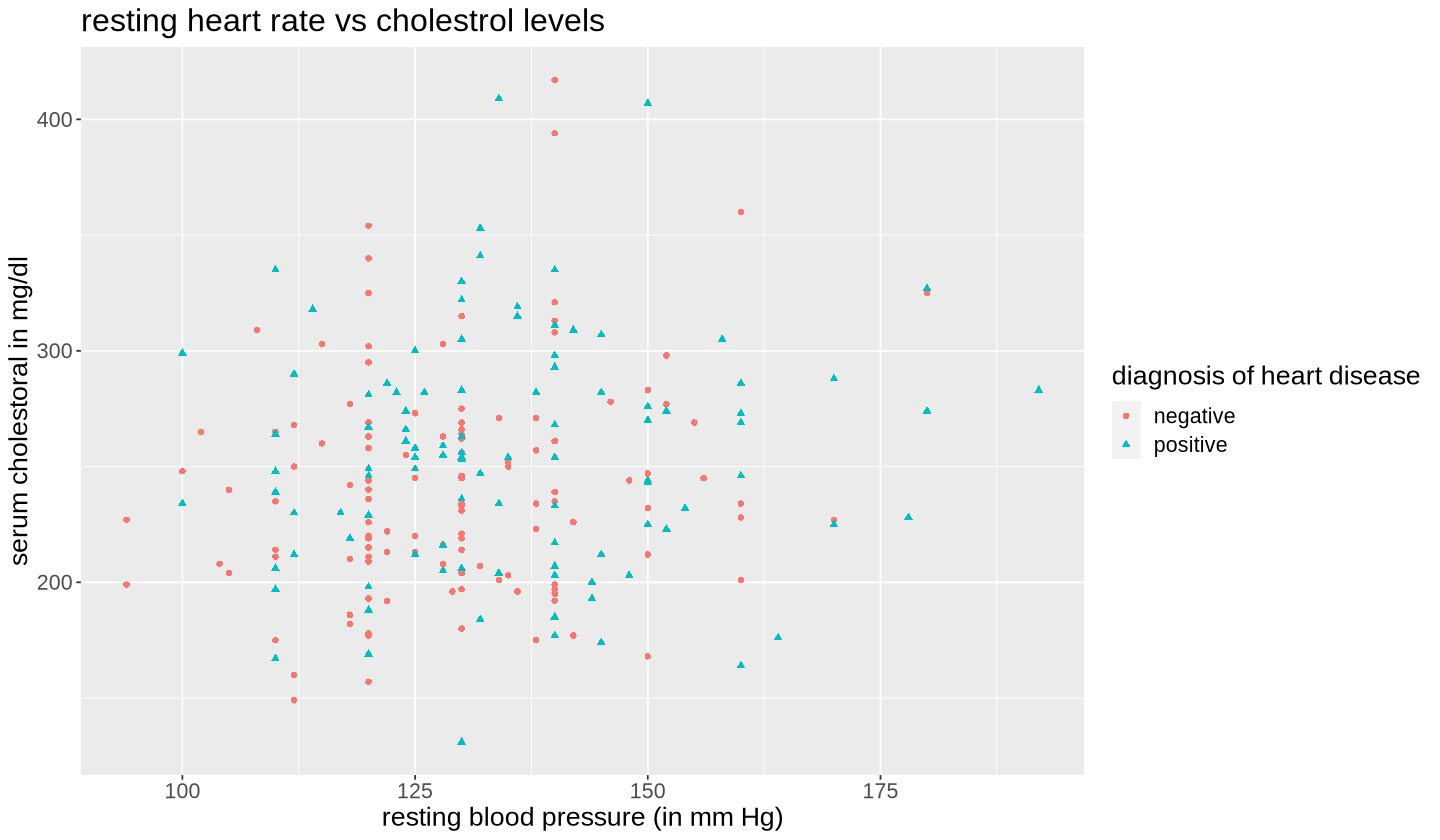

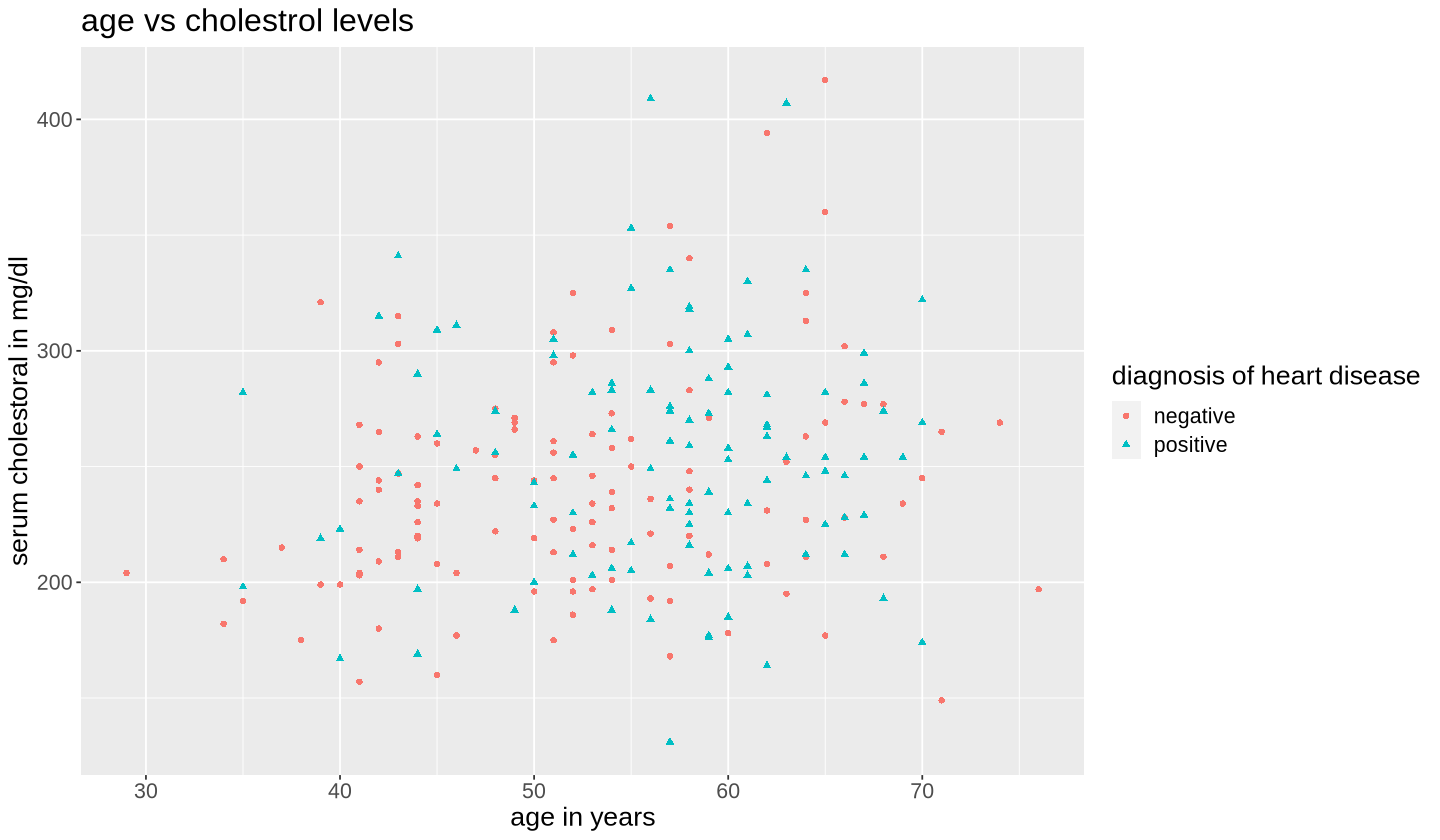

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 7)
plot_1 <- ggplot(heart_training, aes(x = trestbps, y = chol, color = num, shape = num)) +
          geom_point() +
          labs(x = "resting blood pressure (in mm Hg)", 
               y = "serum cholestoral in mg/dl",
               color = "diagnosis of heart disease", 
               shape = "diagnosis of heart disease") +
          theme(text = element_text(size = 16)) +
          ggtitle("resting heart rate vs cholestrol levels")
plot_1

plot_2 <- ggplot(heart_training, aes(x = age, y = chol, color = num, shape = num)) +
          geom_point() +
          labs(x = "age in years", 
               y = "serum cholestoral in mg/dl",
               color = "diagnosis of heart disease",
               shape = "diagnosis of heart disease") +
          theme(text = element_text(size = 16)) +
          ggtitle("age vs cholestrol levels")
plot_2

plot_3 <- ggplot(heart_training, aes(x = age, y = trestbps, color = num, shape = num)) +
          geom_point() +
          labs(x = "age in years", 
               y = "resting blood pressure (in mm Hg)",
               color = "diagnosis of heart disease",
               shape = "diagnosis of heart disease") +
          theme(text = element_text(size = 16)) +
          ggtitle("age vs resting heart rate")
plot_3


### Methods
To clean the data, we needed a way to convert the num row which shows the severity of the heart disease to simply showing whether a patient has heart disease or not. To do so, we used the mutate function to replace all the integers in num with “positive” if heart disease is found and “negative” if heart disease is not found. We also only selected the columns containing the variables we want to use for our analysis.

We want to answer our question through the k-nearest neighbour algorithm. We plan to only use the columns num, which is what we will be determining, and chol, trestbps, and age as our predictors. From our summary tables and visualisations, we notice that the higher resting heart rate, age or cholesterol is the more likely the person is to have a heart disease is. 

From there, we want to scale and centre our data. We then want to create our training data and testing data, using the initial_split() method, by splitting it 75% and 25% respectively. We will do stratifying by num, which contains data on whether heart disease is there or not there. For the analysis, we only used training data. The training data will then be used to create a k-nearest neighbour model. We will then use cross-validation to determine the effectiveness of our model and test it against our testing data.

We plan to visualise our results through a line plot comparing the number of neighbours used compared to the accuracy of predictions. This would help us decide on the ideal number of neighbours to predict whether someone has heart disease or not. 


### Expected Outcome and Significance:
If the patient is older, we expect a higher chance of heart disease to be found. Additionally, higher cholesterol should mean that there is a higher chance of heart disease being found. We also believe that high blood pressure should result in heart disease. 

Having a classification method to determine heart disease should help doctors diagnose their patient with less error, and more efficiency. 

Based on our findings, further research can be conducted on: 
What are effective ways to lower cholesterol levels in older individuals?
Out of the factors present in someone’s health, what is the most important factor to consider when treating a patient with heart disease?